In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
    
df = pd.read_csv('../../data/imp_exp_prod_flat_all.csv')
df.drop(columns='Row Number', inplace=True)
df = df[['Area', 'Item', 'Year', 'Production', 'Import Quantity', 'Export Quantity']]
df.rename(columns={'Area': 'Country', 'Item':'Produce', 'Production':'Production Quantity'}, inplace=True)
df.head()

,Country,Produce,Year,Production Quantity,Import Quantity,Export Quantity
0,Armenia,Potatoes,2000,290260.0,390.0,300.0
1,Armenia,Potatoes,2001,363834.0,2290.0,0.0
2,Armenia,Potatoes,2002,374263.0,1918.0,0.0
3,Armenia,Potatoes,2003,507518.0,2853.0,7.0
4,Armenia,Potatoes,2004,576427.0,1553.0,0.0


In [2]:
# create a lookup table for countries and their centroid locations
lookup = pd.read_csv('../../data/country_centroids.csv')
lookup.rename(columns={'country':'code'}, inplace=True)
lookup.index = lookup['name']
(lookup.drop(columns=['name'])).to_csv('../../data/countries_lookup.csv')


# FIXME --------------------------------------------------------------------------
# ********************************************************************************
# Assuming that China is a sum of mainland, taiwan, hong kong and macao
# 'Serbia and Montenegro' - set coordinates to average of Serbia and Montenegro
# 'South Sudan' and 'Sudan (former)'- set coordinates to Sudan's coordinates

# print regions that are not present in the countries lookup table
set(df[~df['Country'].isin(lookup['name'])]['Country'])

{'Africa',
 'Americas',
 'Asia',
 'Australia & New Zealand',
 'Caribbean',
 'Central America',
 'Central Asia',
 'China',
 'Eastern Africa',
 'Eastern Asia',
 'Eastern Europe',
 'Europe',
 'European Union',
 'Land Locked Developing Countries',
 'Least Developed Countries',
 'Low Income Food Deficit Countries',
 'Melanesia',
 'Middle Africa',
 'Net Food Importing Developing Countries',
 'Northern Africa',
 'Northern America',
 'Northern Europe',
 'Occupied Palestinian Territory',
 'Oceania',
 'Polynesia',
 'Small Island Developing States',
 'South America',
 'South-Eastern Asia',
 'Southern Africa',
 'Southern Asia',
 'Southern Europe',
 'Western Africa',
 'Western Asia',
 'Western Europe',
 'World'}

In [3]:
# remove the regions printed above from the dataframe
df = df[df['Country'].isin(lookup.index)]

# randomly print 10 entries from the dataframe for an example of what it contains
df.sample(n=10)

,Country,Produce,Year,Production Quantity,Import Quantity,Export Quantity
85889,Chile,Maize,2007,1122648.0,1764220.0,74622.0
157379,Hungary,Potatoes,2002,752244.0,32416.0,0.0
152091,Greece,Sweet potatoes,2001,5093.0,469.0,701.0
132583,Belarus,Buckwheat,2007,12997.0,2372.0,0.0
152093,Greece,Sweet potatoes,2003,7512.0,1266.0,1503.0
28723,Netherlands,"Broad beans, horse beans, dry",2004,3400.0,675.0,538.0
43013,Zimbabwe,"Tobacco, unmanufactured",2003,93514.0,4064.0,135405.0
149553,Germany,Sugar beet,2014,29748100.0,286462.0,37779.0
22034,Mali,Bananas,2012,149539.0,16934.0,0.0
89149,Costa Rica,Soybeans,2005,0.0,257700.0,69.0


In [4]:
def getMaximumQuantity(selectedData):
    maxRow = selectedData.nlargest(1, ['Production Quantity', 'Import Quantity', 'Export Quantity'])
    return int(maxRow.loc[:,['Production Quantity', 'Import Quantity', 'Export Quantity']].max(axis=1))
    
# calculate top 10 producers, importers and exporters for each produce in each year
top10_statistics = {}
top10_statistics['produce'] = produceSet = sorted(set(df['Produce']))

for produce in produceSet: 
    # log available years for the given produce
    yearStatistics = {}
    years = sorted(set(df[df['Produce'] == produce]['Year']))
    yearStatistics['available_years'] = years
    
    # log the largest quantity across all years
    yearStatistics['largest_quantity'] = getMaximumQuantity(df[df['Produce'] == produce])
    
    for year in years:
        selected = df[(df['Produce'] == produce) & (df['Year'] == year)]
        
        # log top 10 producers, importers, and exporters, plus the largest quantity for each year
        topProducers = selected.nlargest(10, 'Production Quantity')
        topImporters = selected.nlargest(10, 'Import Quantity')
        topExporters = selected.nlargest(10, 'Export Quantity')
        yearStatistics[year] = {
            'largest_quantity': getMaximumQuantity(selected),
            'Producers': {
                'countries': list(topProducers['Country']),
                'production': list(topProducers['Production Quantity']),
                'import': list(topProducers['Import Quantity']),
                'export': list(topProducers['Export Quantity'])
            },
            'Importers': {
                'countries': list(topImporters['Country']),
                'production': list(topImporters['Production Quantity']),
                'import': list(topImporters['Import Quantity']),
                'export': list(topImporters['Export Quantity'])
            },
            'Exporters': {
                'countries': list(topExporters['Country']),
                'production': list(topExporters['Production Quantity']),
                'import': list(topExporters['Import Quantity']),
                'export': list(topExporters['Export Quantity'])
            }
        }
        
    top10_statistics[produce] = yearStatistics

In [5]:
# dump top 10 statistics to a json file
json.dump(top10_statistics, open('../../data/top10_countries.json', 'w'))

['#f77189', '#50b131', '#3ba3ec']

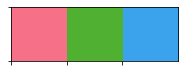

In [6]:
# generate colors for the bar chart
barChartPalette = sns.color_palette('husl', 3)
sns.palplot(barChartPalette)
barChartPalette.as_hex()